In [1]:
using LinearAlgebra

using Distributions
using Random
using HypothesisTests

using Plots
using LaTeXStrings

In [2]:
function N(x)
    return [1 - im*x/2  -im*x/2;
            im *x/2      1 + im*x/2]
end

function K(θ)
    return [exp(im*θ)  0;
            0      exp(-im*θ)]
end

function A(t)
    return [cosh(t)  sinh(t);
            sinh(t)  cosh(t)]
end

A (generic function with 1 method)

In [3]:
function ensemble_KAK(n_matrices::Int, n_samples::Int, component::Tuple{Int,Int}, distribution_θ, distribution_t, distribution_x)
    samples = ComplexF64[]

    for _ in 1:n_samples
        M = I(2)  
        θ_total = 0.0  
        for _ in 1:n_matrices
            x = rand(distribution_x)
            θ = rand(distribution_θ)
            t = rand(distribution_t)
            θ_total += θ
            M *= K(θ)*A(t)*K(x)
        end

        push!(samples, M[component...])
    end
    return samples
end

ensemble_KAK (generic function with 1 method)

In [4]:
function ensemble_KAN(n_matrices::Int, n_samples::Int, component::Tuple{Int,Int}, distribution_θ, distribution_t, distribution_x)
    samples = ComplexF64[]

    for _ in 1:n_samples
        M = I(2)  
        θ_total = 0.0  
        for _ in 1:n_matrices
            x = rand(distribution_x)
            θ = rand(distribution_θ)
            t = rand(distribution_t)
            θ_total += θ
            M *= K(θ)*A(t)*N(x)
        end

        push!(samples, M[component...])
    end
    return samples
end

ensemble_KAN (generic function with 1 method)

In [13]:
n_frames = 150
results = Vector{Tuple{Vector{Float64}, Vector{Float64}}}(undef, n_frames)

Threads.@threads for dispersores in 1:n_frames
    M_12 = ensemble_KAK(dispersores, 20000, (1,2), Normal(2*pi, 2), Normal(0.0, 0.1), Normal(2*pi, 2))
    lamb = abs2.(M_12)
    M_12_b = ensemble_KAK(dispersores, 20000, (1,2), truncated(Normal(0,2), lower=0), Normal(0.0, 0.1), truncated(Normal(0,2), lower=0))
    lamb_b = abs2.(M_12_b)
    #M_12_b = ensemble_KAN(dispersores, 20000, (1,2), Normal(2*pi, 0.1), Normal(0.0, 0.1), Normal(0.0, 0.1))#truncated(Normal(0,0.1), lower=0)
    #lamb_b = abs2.(M_12_b)
    results[dispersores] = (lamb, lamb_b)
end

bin_edges = range(0, 5, length=101)

anim_lamb_n = @animate for dispersores in 1:n_frames
    lamb, lamb_b = results[dispersores]
    h1 = histogram(
        lamb,
        bins=bin_edges,  
        normalize=:pdf,
        alpha=0.7,
        title="Distribución normal para θ",
        xlabel=L"λ=|M_{12}|^{2}",
        ylabel=L"ρ(λ)",
        label=false,
        xlim=(0, 5),
        ylim=(0, 5.5)
    )
    h2 = histogram(
        lamb_b,
        bins=bin_edges,  
        normalize=:pdf,
        alpha=0.7,
        title="Distribución normal truncada para θ",
        xlabel=L"λ=|M_{12}|^{2}",
        ylabel=L"ρ(λ)",
        label=false,
        xlim=(0, 5),
        ylim=(0, 5.5)
    )
    plot(h1, h2, layout=(1,2), size=(1100,500))
end

Animation("C:\\Users\\willi\\AppData\\Local\\Temp\\jl_THwzNM", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000141.png", "000142.png", "000143.png", "000144.png", "000145.png", "000146.png", "000147.png", "000148.png", "000149.png", "000150.png"])

┌ Info: Saved animation to d:\willi\Documents\Documentos_HDD\TESIS_MAESTRIA\Tesis\Chi_sq\histograma_lambda_general.gif
└ @ Plots C:\Users\willi\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\willi\\Documents\\Documentos_HDD\\TESIS_MAESTRIA\\Tesis\\Chi_sq\\histograma_lambda_general.gif")
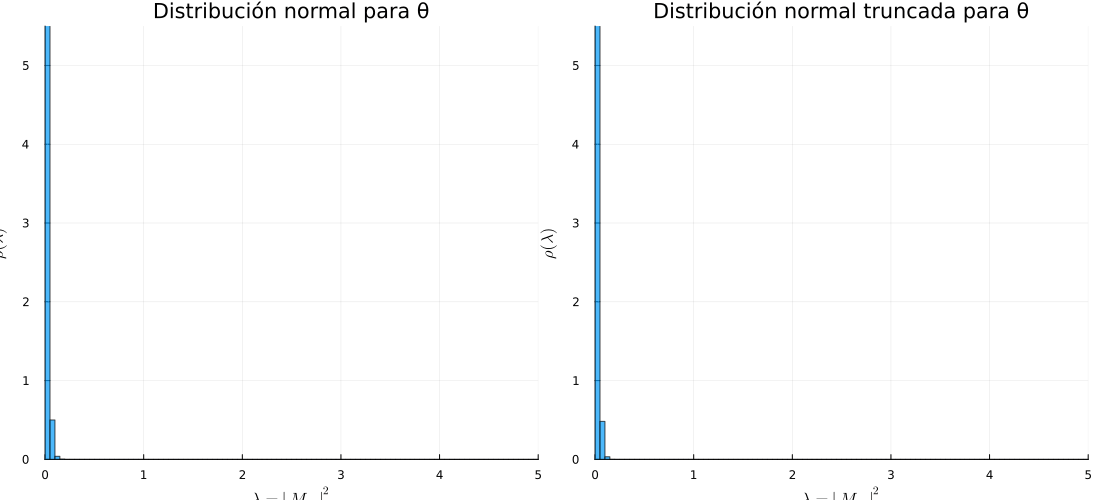

In [14]:
gif(anim_lamb_n, "histograma_lambda_general.gif", fps=10)

In [6]:
# Parámetros
λ_max = 4.0
n_points = 10000
Δλ = (λ_max) / n_points
λ = range(0.0, λ_max, length=n_points)


n_frames=200
pasos_por_frame = 10
Δt = 0.00022  # Paso temporal
t_max = n_frames * pasos_por_frame * Δt  # Tiempo de simulación
nt = Int(floor(t_max / Δt))

2000

┌ Info: Saved animation to d:\willi\Documents\Documentos_HDD\TESIS_MAESTRIA\Tesis\Chi_sq\dmpk_dirichlet.gif
└ @ Plots C:\Users\willi\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\willi\\Documents\\Documentos_HDD\\TESIS_MAESTRIA\\Tesis\\Chi_sq\\dmpk_dirichlet.gif")
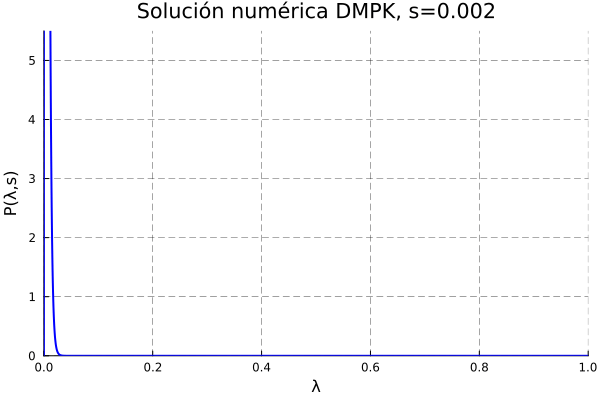

In [7]:
# Funciones de difusión y deriva
D(λ_val) = λ_val * (1 + λ_val)
mu(λ_val) = 1 + 2*λ_val

# Condición inicial: Distribución gaussiana muy estrecha
σ_b=0.001
ρ = 2*exp.(-λ.^2 / (2*σ_b^2))/ sqrt(2*π*σ_b^2)

dmpk_solutions = Vector{Vector{Float64}}(undef, n_frames)

anim = @animate for frame in 1:n_frames
    global ρ

    dmpk_solutions[frame] = copy(ρ)
    # solución del sistema hasta s_deseado
    for _ in 1:pasos_por_frame
        α = Δt / (2 * Δλ^2)
        β = Δλ / 2
        
        N = length(ρ)
    
        # Vectores para las diagonales de A
        dl_A = zeros(N-1)  # diagonal inferior
        d_A = zeros(N)      # diagonal principal
        du_A = zeros(N-1)   # diagonal superior
    
        # Vectores para las diagonales de B
        dl_B = zeros(N-1)   # diagonal inferior
        d_B = zeros(N)      # diagonal principal
        du_B = zeros(N-1)   # diagonal superior
        
        # Llenar las diagonales para los puntos interiores
        for i in 2:N-1
            # Diagonal principal
            d_A[i] = 1 + α * 2 * D(λ[i])
            d_B[i] = 1 - α * 2 * D(λ[i])
            
            # Términos adyacentes (diagonales inferior y superior)
            dl_A[i-1] = -α * (D(λ[i]) - β * mu(λ[i]))
            du_A[i] = -α * (D(λ[i]) + β * mu(λ[i]))
            
            dl_B[i-1] = α * (D(λ[i]) - β * mu(λ[i]))
            du_B[i] = α * (D(λ[i]) + β * mu(λ[i]))
        end
        
        # Condiciones de frontera Dirichlet
        # Para la matriz A
        d_A[1] = 1
        du_A[1] = 0
        d_A[end] = 1
        dl_A[end] = 0
    
        # Para la matriz B (todos ceros en las fronteras)
        d_B[1] = 0
        du_B[1] = 0 
        d_B[end] = 0
        dl_B[end] = 0
    
        # Construir matrices tridiagonales
        A = Tridiagonal(dl_A, d_A, du_A)
        B = Tridiagonal(dl_B, d_B, du_B)

        # Resolver el sistema lineal
        ρ = A \ (B * ρ)
    end
    # Crear el plot
    tiempo = frame * pasos_por_frame * Δt
    plot(λ, ρ, 
         lw=2, 
         color=:blue, 
         xlims=(0, 1),
         ylims=(0, 5.5),
         #ylims=(0, 1.1*maximum(P)),
         title="Solución numérica DMPK, s=$(round(tiempo, digits=3))",
         xlabel="λ", 
         ylabel="P(λ,s)",
         legend=false,
         grid=true, 
         gridstyle=:dash, 
         gridalpha=0.7)
end

# Guardar la animación
gif(anim, "dmpk_dirichlet.gif", fps=10)


In [8]:
function ensemble(n_matrices::Int, n_samples::Int, component::Tuple{Int,Int}, distribution_x, distribution_θ)
    samples = ComplexF64[]

    for _ in 1:n_samples
        M = I(2)  
        θ_total = 0.0  
        for _ in 1:n_matrices
            x = rand(distribution_x)
            θ = rand(distribution_θ)
            θ_total += θ
            M *= N(x)*K(θ)
        end
        K(-θ_total)
        M = K(θ_total) * M 

        push!(samples, M[component...])
    end
    return samples
end

ensemble (generic function with 1 method)

┌ Info: Saved animation to d:\willi\Documents\Documentos_HDD\TESIS_MAESTRIA\Tesis\Chi_sq\histograma_lambda_prueba.gif
└ @ Plots C:\Users\willi\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\willi\\Documents\\Documentos_HDD\\TESIS_MAESTRIA\\Tesis\\Chi_sq\\histograma_lambda_prueba.gif")
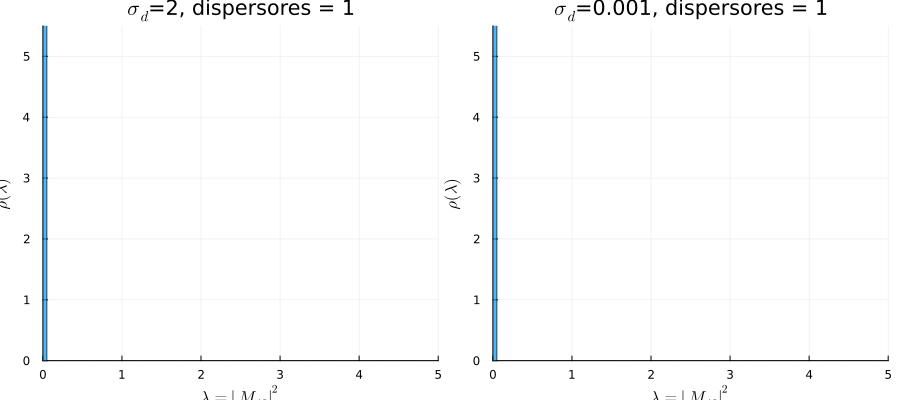

In [9]:
n_deltas = 200
σ_id = 0.001
σ_dmpk = 2
res = Vector{Tuple{Vector{Float64}, Vector{Float64}}}(undef, n_deltas)

Threads.@threads for dispersores in 1:n_deltas
    M_12_delta = ensemble(dispersores, 10000, (1,2), Normal(0.0, 0.1), truncated(Normal(0,σ_dmpk), lower=0))
    lamb_delt = abs2.(M_12_delta)
    M_12_delta_0 = ensemble(dispersores, 10000, (1,2), Normal(0.0, 0.1), truncated(Normal(0,σ_id), lower=0))
    lamb_delt_0 = abs2.(M_12_delta_0)
    res[dispersores] = (lamb_delt, lamb_delt_0)
end

bin_edges0 = range(0, 5, length=101)  # 101 puntos para 100 bins

anim_lamb_delta = @animate for dispersores in 1:n_deltas
    lamb_delt, lamb_delt_0 = res[dispersores]
    a1 = histogram(
        lamb_delt,
        bins=bin_edges0,  
        normalize=:pdf,
        alpha=0.7,
        title="\$σ_d\$=$σ_dmpk, dispersores = $dispersores",
        xlabel=L"λ=|M_{12}|^{2}",
        ylabel=L"ρ(λ)",
        label=false,
        xlim=(0, 5),
        ylim=(0, 5.5)
    )
    a2 = histogram(
        lamb_delt_0,
        bins=bin_edges0,  
        normalize=:pdf,
        alpha=0.7,
        title="\$σ_d\$=$σ_id, dispersores = $dispersores",
        xlabel=L"λ=|M_{12}|^{2}",
        ylabel=L"ρ(λ)",
        label=false,
        xlim=(0, 5),
        ylim=(0, 5.5)
    )
    plot(a1, a2, layout=(1,2), size=(900,400))
end
gif(anim_lamb_delta, "histograma_lambda_prueba.gif", fps=10)

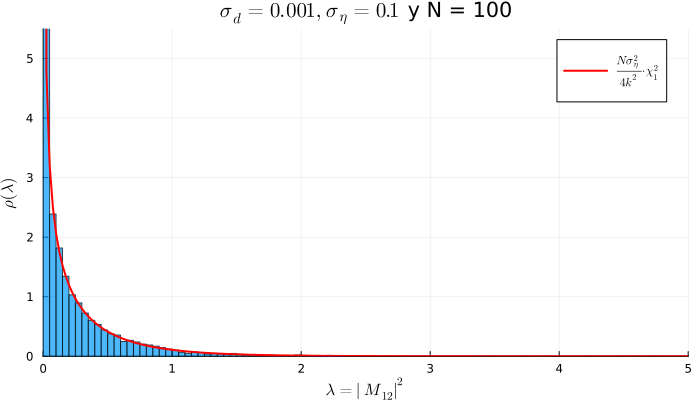

In [10]:
function PT(λ,N,σ_η)
    return 2 ./sqrt.(2*π*N*σ_η^2*λ) .* exp.(-2 .*λ./(N*σ_η^2))
end

N_dis=100
lambda = range(0.0001, 5, length=200)
pdf=PT(lambda, N_dis, 0.1)

M_12_100_delta = ensemble(N_dis, 10000, (1,2), Normal(0.0, 0.1), Normal(2*π, 0.001))
bin_edges_0 = range(0, 5, length=101)

hist=histogram(abs2.(M_12_100_delta), bins=bin_edges_0, normalize=:pdf, alpha=0.7, title="\$σ_d=0.001, σ_η=0.1\$ y N = $N_dis", xlabel=L"λ=|M_{12}|^{2}", ylabel=L"ρ(λ)", label=false, xlim=(0, 5), ylim=(0, 5.5))
p=plot(hist, size=(700, 400))
plot!(lambda, pdf, lw=2, label=L"\frac{N σ_η^2}{4k^2} ⋅ χ_1^2", color=:red)
ylims!(0,5.5)
#savefig(p, "Chi_cuadrada_100_deltas.png")

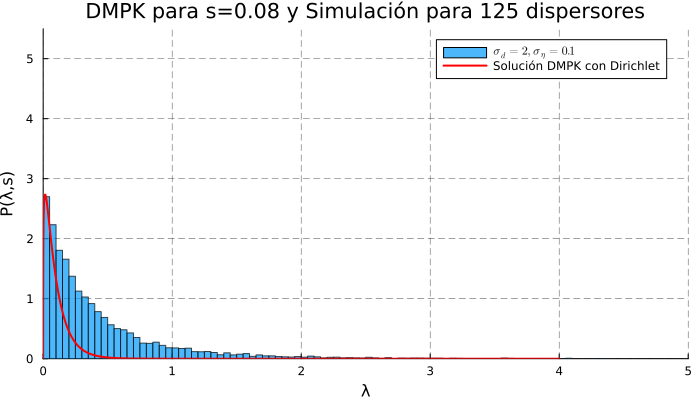

In [18]:
s_deseado = 0.08  # Elige el tiempo que quieras entre 0 y t_max 
frame = Int(round(s_deseado / (pasos_por_frame * Δt)))
frame = clamp(frame, 1, n_frames)  # Asegura que esté en el rango válido

P_fijo = dmpk_solutions[frame]

N_deltas = 125

M_12_125_delta = ensemble(N_deltas, 10000, (1,2), Normal(0.0, 0.1), Normal(2*π, 2))
bin_edges_0 = range(0, 5, length=101)

hist=histogram(abs2.(M_12_125_delta), bins=bin_edges_0, normalize=:pdf, alpha=0.7, title="\$σ_d=10^{-5}, σ_η=0.1\$ y N = $N_dis", xlabel=L"λ=|M_{12}|^{2}", ylabel=L"ρ(λ)", label=L"σ_d=2, σ_η=0.1", xlim=(0, 5), ylim=(0, 5.5))
p_1=plot(hist, size=(700, 400))

plot!(λ, P_fijo,
     lw=2,
     color=:red,
     xlims=(0, 5),
     ylims=(0, 5.5),
     label="Solución DMPK con Dirichlet",
     xlabel="λ",
     ylabel="P(λ,s)",
     grid=true,
     gridstyle=:dash,
     gridalpha=0.7)

ylims!(0,5.5)
xlims!(0,5)
title!("DMPK para s=$s_deseado y Simulación para $N_deltas dispersores")
#savefig(p_1, "DMPK_125_deltas.png")

┌ Info: Saved animation to d:\willi\Documents\Documentos_HDD\TESIS_MAESTRIA\Tesis\Chi_sq\animacion_para_sd_0.gif
└ @ Plots C:\Users\willi\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\willi\\Documents\\Documentos_HDD\\TESIS_MAESTRIA\\Tesis\\Chi_sq\\animacion_para_sd_0.gif")
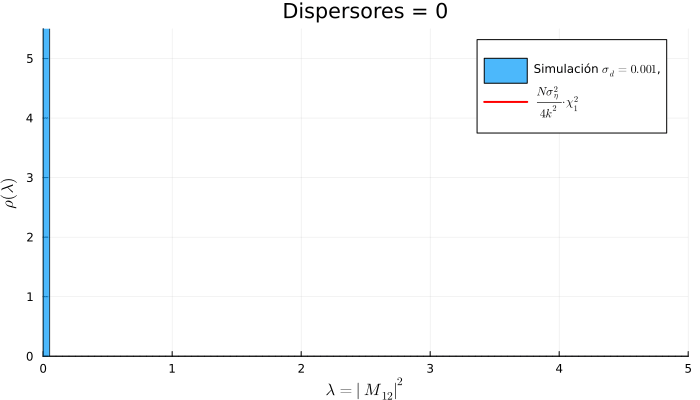

In [12]:
λ_teo = range(1e-4, 5, length=200)
σ_η = 0.1
n_frames = 200  # Número de valores de N_dis a animar
N_dis_values = round.(Int, range(0, 200, length=n_frames)) 

bin_edges_0 = range(0, 5, length=101)

anim = @animate for (i, N_dis) in enumerate(N_dis_values)
    # Simulación
    M_12_delta = ensemble(N_dis, 5000, (1,2), Normal(0.0, 0.1), Normal(2*π, 0.001))
    lambdas = abs2.(M_12_delta)
    # Teoría
    pdf = PT(λ_teo, N_dis, σ_η)
    # Histograma + teoría
    hist = histogram(
        lambdas,
        bins=bin_edges_0,
        normalize=:pdf,
        alpha=0.7,
        title="Dispersores = $N_dis",
        xlabel=L"λ=|M_{12}|^{2}",
        ylabel=L"ρ(λ)",
        label="Simulación \$σ_d=0.001\$,",
        xlim=(0, 5),
        ylim=(0, 5.5),
        size=(700, 400)
    )
    plot!(λ_teo, pdf, lw=2, label=L"\frac{N σ_η^2}{4k^2} ⋅ χ_1^2", color=:red)
end

gif(anim, "animacion_para_sd_0.gif", fps=10)